In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from imutils import paths
import os
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam




In [2]:
! pip install imutils 

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=8afbfad30d466aebee2c6d251c2b561cf263f5dbafe831be3065b3d1fa7d0417
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [4]:
print(tf.__version__)

2.6.0


In [5]:
#set seed number:
import random
random.seed(99)

**1 - Importing kaggle Data Train_Val Set**

Use /tmp to create temporary folder

In [6]:
!ls /

NGC-DL-CONTAINER-LICENSE  entrypoint.sh  lib	opt   run_jupyter.sh  sys
bin			  etc		 lib64	proc  sbin	      tmp
boot			  home		 media	root  src	      usr
dev			  kaggle	 mnt	run   srv	      var


In [7]:
!mkdir /tmp/Xray_train_data


In [21]:
!cp -R "../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID" "/tmp/Xray_train_data"
!cp -R "../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal" "/tmp/Xray_train_data"

In [9]:
!ls /tmp/Xray_train_data/

COVID  Normal


In [10]:
print("Number of COVID images:")
!ls -1 "/tmp/Xray_train_data/COVID"| wc -l 

Number of COVID images:
3616


In [11]:
print("Number of NORMAL images:")
!ls -1 "/tmp/Xray_train_data/Normal"| wc -l 

Number of NORMAL images:
10061


In [12]:
data_dir= "/tmp/Xray_train_data"
all_imgs=sorted(list(paths.list_images(data_dir)))

random.shuffle(all_imgs)

train_filenames, test_filenames = train_test_split(all_imgs, test_size=0.1)

print("Number of TRAIN/VALID images:",len(train_filenames))
print("Number of TEST images:",len(test_filenames))

b ='/tmp/Xray_train_data/COVID/COVID-1.png'
print(b.split(os.path.sep)[3])

Number of TRAIN/VALID images: 12309
Number of TEST images: 1368
COVID


In [13]:
#Create temporary folder for TEST images
!mkdir /tmp/Xray_train_data/test
!mkdir /tmp/Xray_train_data/test/COVID
!mkdir /tmp/Xray_train_data/test/Normal

#Create temporary folder for Train/Valid images
!mkdir /tmp/Xray_train_data/train
!mkdir /tmp/Xray_train_data/train/COVID
!mkdir /tmp/Xray_train_data/train/Normal

!ls '/tmp/Xray_train_data/train'

COVID  Normal


In [14]:
#Copy the Test images into created folders
for x in test_filenames:    
    if (x.split(os.path.sep)[3] == 'COVID'):
        shutil.copy(x, "/tmp/Xray_train_data/test/COVID")      
    if (x.split(os.path.sep)[3] == 'Normal'):
        shutil.copy(x, "/tmp/Xray_train_data/test/Normal")
            
#Copy the Train/Valid images into created folders    
for x in train_filenames:  
    if (x.split(os.path.sep)[3] == 'COVID'):
        shutil.copy(x, "/tmp/Xray_train_data/train/COVID")       
    if (x.split(os.path.sep)[3] == 'Normal'):
        shutil.copy(x, "/tmp/Xray_train_data/train/Normal")
            

In [15]:
#check again the number of each group:
print("Number of Train/Valid images at the new location:",len(sorted(list(paths.list_images('/tmp/Xray_train_data/train/')))))
print("Number of Test images at the new location::",len(sorted(list(paths.list_images('/tmp/Xray_train_data/test/')))))

Number of Train/Valid images at the new location: 12309
Number of Test images at the new location:: 1368


**2 - Preproseccing and Augmentaion Pipeline**

In [16]:
#set the data locations
train_data_dir= "/tmp/Xray_train_data/train"
test_data_dir= "/tmp/Xray_train_data/test"

In [17]:
#defines:
img_height, img_width=224,224
batch_size=64

In [18]:
#set the pipeline for Preprocessing and Augmentaion for Train/Valid:
train_datagen = ImageDataGenerator(validation_split=0.13,   #set validation split
                             rescale=1./255,           #rescaling into [0,1]
                             vertical_flip=True,       #augmentation  
                             horizontal_flip=True)     #augmentation

#set the pipeline for Preprocessing for Test:
test_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
#creat generator for Train data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=99)

#creat generator for Validation data
validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True,
    seed=99) 

#creat generator for Test data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary',
    #subset='validation',
    shuffle=True,
    seed=99)

Found 10709 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1368 images belonging to 2 classes.


**3- Create the Model**

In [20]:

pretrained_base= tf.keras.applications.densenet.DenseNet201(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

x = pretrained_base.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(256, activation='relu',kernel_initializer='he_uniform')(x)
x = tf.keras.layers.BatchNormalization()(x)
y = tf.keras.layers.Dropout(0.3)(x)

p = tf.keras.layers.Dense(2, activation='softmax')(y)

model = Model(inputs=pretrained_base.input, outputs=p)

#model.summery()

2021-10-17 12:56:51.046618: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-17 12:56:51.137760: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-17 12:56:51.138537: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-17 12:56:51.140002: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

74850304/74836368 [==============================] - 1s 0us/step


In [22]:
model.compile(optimizer=Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
              loss='sparse_categorical_crossentropy',   #'binary_crossentropy'
              metrics = ['accuracy'])

In [23]:
print("STEP_SIZE_TRAIN:",(train_generator.n//train_generator.batch_size))

STEP_SIZE_TRAIN: 167


**4- Training**

In [24]:
#to avoid overfitting
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=4)

# Training the model
trainer=model.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=30,
                  steps_per_epoch=160,
                  verbose=2,
                  callbacks=[early]
                  )

2021-10-17 12:57:19.832599: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2021-10-17 12:57:39.575235: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


160/160 - 123s - loss: 0.5780 - accuracy: 0.7490 - val_loss: 0.3749 - val_accuracy: 0.8475
Epoch 2/30
160/160 - 90s - loss: 0.2511 - accuracy: 0.8996 - val_loss: 0.4129 - val_accuracy: 0.8350
Epoch 3/30
160/160 - 90s - loss: 0.1552 - accuracy: 0.9466 - val_loss: 0.2947 - val_accuracy: 0.8825
Epoch 4/30
160/160 - 90s - loss: 0.1063 - accuracy: 0.9650 - val_loss: 0.3707 - val_accuracy: 0.8631
Epoch 5/30
160/160 - 90s - loss: 0.0827 - accuracy: 0.9734 - val_loss: 0.0923 - val_accuracy: 0.9694
Epoch 6/30
160/160 - 90s - loss: 0.0624 - accuracy: 0.9808 - val_loss: 0.1767 - val_accuracy: 0.9450
Epoch 7/30
160/160 - 90s - loss: 0.0495 - accuracy: 0.9859 - val_loss: 0.0511 - val_accuracy: 0.9837
Epoch 8/30
160/160 - 90s - loss: 0.0404 - accuracy: 0.9889 - val_loss: 0.0399 - val_accuracy: 0.9894
Epoch 9/30
160/160 - 90s - loss: 0.0328 - accuracy: 0.9903 - val_loss: 0.0391 - val_accuracy: 0.9894
Epoch 10/30
160/160 - 90s - loss: 0.0282 - accuracy: 0.9915 - val_loss: 0.0315 - val_accuracy: 0.9894

**5- Evaluate and Results:**

In [25]:
print('Evaluate on test-data:')
model.evaluate(test_generator)

Evaluate on test-data:
43/43 [==============================] - 7s 138ms/step - loss: 0.0213 - accuracy: 0.9934


[0.021315287798643112, 0.9934210777282715]

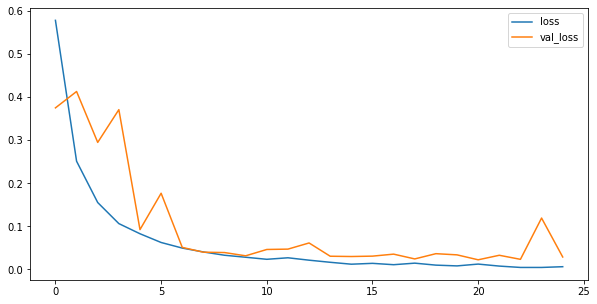

In [26]:
# Plotting train_loss vs val_loss
plt.figure(figsize=(10,5))
plt.plot(trainer.history["loss"],label="loss")
plt.plot(trainer.history["val_loss"],label="val_loss")
plt.legend()

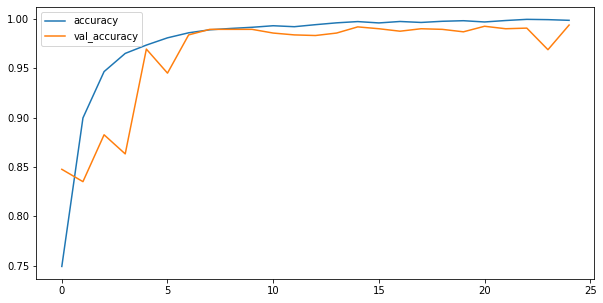

In [27]:
# Plotting train_accuracy vs Val_accuracy
plt.figure(figsize=(10,5))
plt.plot(trainer.history["accuracy"],label="accuracy")
plt.plot(trainer.history["val_accuracy"],label="val_accuracy")
plt.legend(loc='upper left')

In [36]:

model.save("my_model")

In [35]:
2+3

5